<img src="http://www3.ifmg.edu.br/site_campi/p/images/logos/Betim-Simples.png" width="700"></img>
<b>Engenharia de Controle e Automação - Redes neurais artificiais</b> - Prof. Leandro Freitas

### Lucas Pevidor Reis - 0024855 - TP3

# 1  Objetivo

Implementar uma rede neural para estimar o valor de uma função com dois valores de entrada.


# 2 Regressão de uma função de duas variáveis

## 2.1 Função  a ser estimada:

A função a ser estimada é dada por $y = tan^{-1}(0,3x_1 + 0,7x_2)$. Inicialmente são gerados 20 valores de entrada de forma aleatória com distribuição uniforme entre -4 e 4, para $x_1$ e $x_2$;

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

x1 = np.transpose(np.array([np.random.uniform(-4,4,20)]))
x2 = np.transpose(np.array([np.random.uniform(-4,4,20)]))
x = np.append(x1, x2, axis=1)

O valor desejado é dado por $d = tan^{-1}(0.3x_1 + 0.7x_2) + \epsilon$, onde $\epsilon$ é um ruído aleatório, gaussiano de média nula, gerado para cada par $x_1$ e $x_2$

In [2]:
ruido = np.transpose(np.array([np.random.normal(scale=0.1, size=20)]))
d = np.arctan(0.3*x1 + 0.7*x2) + ruido

## 2.2 Criação, treinamento e análise de desempenho das redes neurais

Utilizando os dados gerados, foram treinadas duas redes neurais: uma com função de ativação linear e outra com função de ativação sigmoidal logística, dada por $\varphi(x) = \frac{1}{1+e^{-x}}$.

### 2.2.1 Importação da classe da rede neural:

A classe da rede neural utilizada foi a mesma utilizada para os trabalhos anteriores, mas agora com alterações nas funções de processamento de saída da rede e no processo de treinamento.

In [3]:
class RedeNeural:

    #Função de inicialização da classe
    def __init__(self, n_entradas, func_act, use_bias):
        #Se optar por utilizar bias, será adicionada uma coluna no final dos vetores de entrada com valor unitário.
        self.use_bias = use_bias        
        if use_bias:
            self.pesos = np.empty((n_entradas+1, 1), dtype=float)
        else:
            self.pesos = np.empty((n_entradas, 1), dtype=float)
        self.func_act = func_act
    
    def reset(self):
        #Zerar pesos
        self.pesos = np.zeros((len(self.pesos[:,0]), 1), dtype=float)
            
    #Definição de entradas
    #Função utilizada para configurar o vetor de entrada interno da classe, juntamente com normalização, adição
    #da coluna de bias. Utilizar quando a média e desvpad para normalização ainda não foram definidos.
    def set_entradas_ant(self, entradas, normalizar):        
        if self.use_bias:
            vetor_1 = np.zeros([len(entradas[:,0]), 1]) + 1
            if normalizar:
                self.normalizar(entradas, False)
                self.vetor_entradas = np.append(self.entr_normalizada, vetor_1, axis=1)
            else:
                self.vetor_entradas = np.append(entradas, vetor_1, axis=1)
        else:
            if normalizar:                
                self.vetor_entradas = self.normalizar(entradas, False)
            else:
                self.vetor_entradas = entradas
    
    #Definir entradas após treinamento da rede
    #Função utilizada para configurar o vetor de entrada interno da classe, juntamente com normalização, adição
    #da coluna de bias. Utilizar quando a média e desvpad para normalização ainda JÁ foram definidos.
    def set_entradas_pós(self, entradas, normalizar):
        if self.use_bias:
            vetor_1 = np.zeros([len(entradas[:,0]), 1]) + 1
            if normalizar:            
                self.vetor_entradas = np.append(self.normalizar(entradas, True), vetor_1, axis=1)
            else:
                self.vetor_entradas = np.append(entradas, vetor_1, axis=1)
        else:
            if normalizar:
                self.vetor_entradas = self.normalizar(entradas, True)
            else:                    
                self.vetor_entradas = entradas
    
    def normalizar(self, entradas, utilizar_parametros_anteriores):
        if utilizar_parametros_anteriores == False:
            #Encontrar média e desvio padrão a partir das entradas fornecidas.
            #Executado antes do treinamento da rede
            self.media = np.empty(len(entradas[0,:]), dtype=float)
            self.desvpad = np.empty(len(entradas[0,:]), dtype=float)
            self.entr_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
        
            for i in range(0, len(entradas[0,:])):
                self.media[i] = np.mean(entradas[:,i])
                self.desvpad[i] = np.sqrt(np.var(entradas[:,i]))            
                self.entr_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]
            return self.entr_normalizada
        else:
            #Normaliza os dados de entrada fornecidos conforme a média e desvio padrão já encontrados anteriormente
            entr_nova_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
            for i in range(0, len(entradas[0,:])):                
                entr_nova_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]            
            
            return entr_nova_normalizada    
        
    def proc_saida(self, entradas, normalizado):
        if not normalizado:
            #Normalização das entradas utilizando média e desvpad já encontrados
            entr_nova_normalizada = self.normalizar(entradas, True)
        else:
            entr_nova_normalizada = entradas
        
        v = np.dot(entr_nova_normalizada, self.pesos)
        saida = np.empty([1,1])
        if(self.func_act == 'Bipolar'):    
            for i in range(len(v)):
                if(v[i,:] > 0):
                    saida = np.append(saida, [[1]], axis=0)
                else:
                    saida = np.append(saida, [[-1]], axis=0)
            self.saida = saida[1:]
            return saida[1:]
        
        elif(self.func_act == 'Linear'): ##Adicionada função de ativação linear
            saida = v
            return saida

        elif(self.func_act == 'Sigmoid'): ##Adicionada função de ativação sigmoidal
            saida = 1/(1+np.e**(-v))
            return saida
        
            
    def treinar_rede(self, fator_aprendizado, saida_desejada, max_iterações):
        redeTreinada = False
        self.historicoAcertos = []
        self.historicoPesos = np.empty([len(self.pesos), 1])
        
        for i in range(0, max_iterações):
            if not redeTreinada:
                flagAlteração = False
                acertos = 0
                for j in range(len(self.vetor_entradas[:,0])):
                    #Testa as entradas até encontrar um erro
                    #Caso encontrado, continua testando as outras entradas para obter a quantidade de acertos para
                    #os pesos atuais. Em seguida atualiza os pesos e reinicia os testes.
                    saida_proc = self.proc_saida([self.vetor_entradas[j,:]], True)[0,0]
                    res = saida_desejada[j,0] - saida_proc
                    if res == 0 and self.func_act=='Bipolar':
                        acertos += 1
                    else:
                        if self.func_act == 'Linear' or self.func_act == 'Bipolar':
                        #O processo de treinamento para redes com funções de ativação lineares ou percéptrons é o mesmo
                            deltaW = fator_aprendizado * res * self.vetor_entradas[j,:]
                        elif self.func_act == 'Sigmoid':
                        #Adicionado processo de treinamento para redes com func_ativação sigmoidal
                            deltaW = fator_aprendizado * res * self.vetor_entradas[j,:] * saida_proc * (1 - saida_proc)
                        flagAlteração = True                                                
                        
                        #Se a rede for do tipo percéptron, termina de checar a quantidade de acertos
                        #antes de atualizar os pesos
                        if self.func_act=='Bipolar':
                            for k in range(j+1, len(self.vetor_entradas[:,0])):
                                res = saida_desejada[k,0] - self.proc_saida([self.vetor_entradas[k,:]], True)[0,0]
                                if res == 0:
                                    acertos += 1
                        
                            #Salva os acertos e pesos
                            self.historicoAcertos.append(acertos)
                        self.historicoPesos = np.append(self.historicoPesos, self.pesos, axis=1)
                        
                        #Atualiza os pesos                               
                        self.pesos += np.transpose([deltaW])
                        if self.func_act == 'Bipolar':
                            break
                
                if flagAlteração == False:
                    redeTreinada = True
                    self.historicoAcertos.append(acertos)
                    self.historicoPesos = np.append(self.historicoPesos, self.pesos, axis=1)                
        
        self.historicoErros = []
        for i in range(len(self.historicoAcertos)):            
            self.historicoErros.append(len(self.vetor_entradas) - self.historicoAcertos[i])
        
        if redeTreinada == False:
            if self.func_act=='Bipolar':
                #Se não foi possível obter 100% de acerto durante as iterações
                #encontra e define como pesos os que obtiveram mais acertos
                indiceMax = self.historicoAcertos.index(max(self.historicoAcertos))                        
                self.pesos = np.transpose([self.historicoPesos[:, indiceMax+1]])
                print('Nº erros: {}'.format(len(self.vetor_entradas[:,0])-max(self.historicoAcertos)))

### 2.2.2 Instancialização, treinamento e resultados das redes neurais

Inicialmente foi instancializada a rede neural com função de ativação linear. A rede foi treinada com os dados de entradas normalizados. A rede foi treinada com taxa de aprendizado igual a 0.01. Valores maiores fizeram com que ou a rede apresentasse um erro maior ou não apresentasse convergência.

In [4]:
linearNet = RedeNeural(2, 'Linear', use_bias=True)
linearNet.set_entradas_ant(x, normalizar=True)
linearNet.treinar_rede(0.01, d, 20)

O gráfico abaixo foi plotado para visualizar quanto a rede neural conseguiu aproximar sua saída em relação à saída desejada:

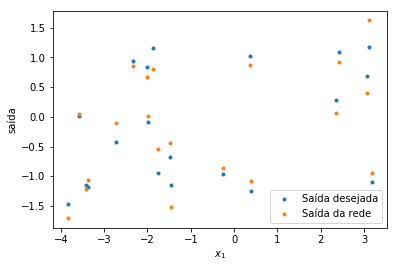

In [5]:
linearNet.set_entradas_pós(x, normalizar=True)
saida_processada = linearNet.proc_saida(linearNet.vetor_entradas, True)

plt.figure()
plt.plot(x[:,0], d, '.', label='Saída desejada')
plt.plot(x[:,0], saida_processada[:,0], '.', label='Saída da rede')
plt.xlabel('$x_1$')
plt.ylabel('saída')
plt.legend()
plt.show()

É possível visualizar que para alguns dados a rede neural se aproximou bastante, mas para maioria houve um erro considerável.

Para mensurar os erros, foi realizado o somatório do erro quadrático médio das amostras em realação à saída desejada para cada iteração de treinamento da rede, como mostrado abaixo:

Erro final: [0.05757176]


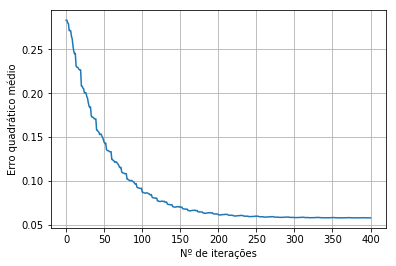

In [6]:
eqm = np.empty([len(linearNet.historicoPesos[0,:]), 1])
for i in range(len(linearNet.historicoPesos[0,:])):
    linearNet.pesos = np.transpose([linearNet.historicoPesos[:,i]])
    saida_processada = np.empty([len(x[:,0]), 1])
    for k in range(len(x[:,0])):
        linearNet.set_entradas_pós(np.array([x[k,:]]), normalizar=True)
        saida_processada[k] = linearNet.proc_saida(linearNet.vetor_entradas, True)
    erros = d - saida_processada
    eqm[i] = np.mean(erros**2)
print('Erro final: {}'.format(eqm[i]))
plt.figure()
plt.plot(eqm)
plt.grid()
plt.xlabel('Nº de iterações')
plt.ylabel('Erro quadrático médio')
plt.show()

Para o treinamento da rede sigmoidal, devido à natureza da função sigmoidal logística, não é possível obter valores de saída menores que 0 ou maiores que 1. Portanto, antes de se efetuar o treinamento o vetor de saídas desejadas foi "normalizado" para ficar entre esta faixa de valores.

Em seguida a rede neural sigmoidal foi instanciada e treinada com os valores de saída desejada normalizados.

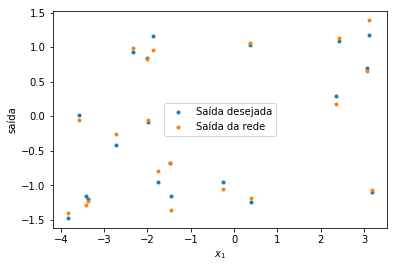

In [7]:
maxD = max(abs(d))
d1 = d/(maxD*2) + 0.5

sigmoidNet = RedeNeural(2, 'Sigmoid', use_bias=True)
sigmoidNet.set_entradas_ant(x, normalizar=True)
sigmoidNet.treinar_rede(2, d1, 20)
saida_processada = (sigmoidNet.proc_saida(sigmoidNet.vetor_entradas, True) - 0.5)*2*maxD

plt.figure()
plt.plot(x[:,0], d, '.', label='Saída desejada')
plt.plot(x[:,0], saida_processada[:,0], '.', label='Saída da rede')
plt.xlabel('$x_1$')
plt.ylabel('saída')
plt.legend()
plt.show()

Percebe-se que a rede neural sigmoidal consegue aproximar a sua saída bem mais à saída dejesada. Isto pode ser confirmado pelo cálculo do somatório do erro quadrático médio, realizado abaixo:

Erro final: [0.01195548]


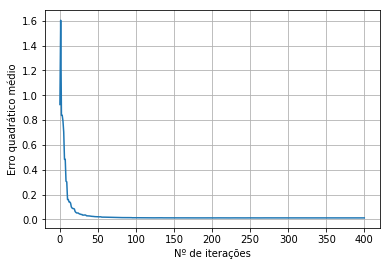

In [8]:
#Encontrando erro quadrático médio da rede sigmoidal por iteração:
eqm = np.empty([len(sigmoidNet.historicoPesos[0,:]), 1])
for i in range(len(sigmoidNet.historicoPesos[0,:])):
    sigmoidNet.pesos = np.transpose([sigmoidNet.historicoPesos[:,i]])
    saida_processada = np.empty([len(x[:,0]), 1])
    for k in range(len(x[:,0])):
        sigmoidNet.set_entradas_pós(np.array([x[k,:]]), normalizar=True)
        saida_processada[k] = (sigmoidNet.proc_saida(sigmoidNet.vetor_entradas, True) - 0.5)*2*maxD
    erros = d - saida_processada
    eqm[i] = np.mean(erros**2)
print('Erro final: {}'.format(eqm[i]))

plt.figure()
plt.plot(eqm)
plt.grid()
plt.xlabel('Nº de iterações')
plt.ylabel('Erro quadrático médio')
plt.show()

Percebe-se também que além de apresentar um erro quadrático médio final muito menor que a rede linear, a rede sigmoidal converge muito mais rápido, necessitando de aproximadamente 50 iterações para alcançar resultados satisfatórios.

### Comparando os resultados obtidos utilizando outro conjunto de dados

O novo conjunto de dados foi gerado da mesma forma que o anterior, mas desta vez sem a adição de ruído:

In [9]:
x21 = np.transpose(np.array([np.random.uniform(-4,4,20)]))
x22 = np.transpose(np.array([np.random.uniform(-4,4,20)]))
x2 = np.append(x21, x22, axis=1)
d2 = np.arctan(0.3*x21 + 0.7*x22)

Com os novos dados para validação e com as redes já treinadas basta então realizar a análise do somatório do erro quadrático médio por iteração das redes linear e sigmoidal:

EQM final da rede linear: [0.03606719]
EQM final da rede sigmoidal: [0.02124117]


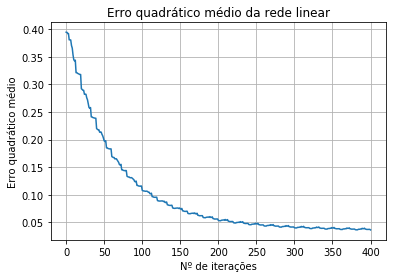

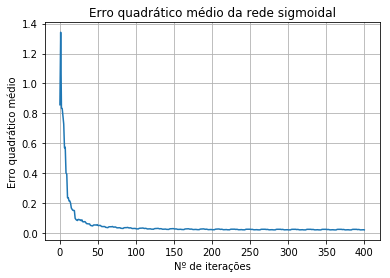

In [10]:
#Encontrando erro quadrático médio por iteração da rede linear:
eqm = np.empty([len(linearNet.historicoPesos[0,:]), 1])
for i in range(len(linearNet.historicoPesos[0,:])):
    linearNet.pesos = np.transpose([linearNet.historicoPesos[:,i]])
    saida_processada = np.empty([len(x[:,0]), 1])
    for k in range(len(x[:,0])):
        linearNet.set_entradas_pós(np.array([x2[k,:]]), normalizar=True)
        saida_processada[k] = linearNet.proc_saida(linearNet.vetor_entradas, True)
    erros = d2 - saida_processada
    eqm[i] = np.mean(erros**2)
print('EQM final da rede linear: {}'.format(eqm[i]))
plt.figure()
plt.plot(eqm)
plt.grid()
plt.title('Erro quadrático médio da rede linear')
plt.xlabel('Nº de iterações')
plt.ylabel('Erro quadrático médio')
#Encontrando erro quadrático médio por iteração da rede sigmoidal:
maxD2 = max(abs(d2))
##########################
eqm = np.empty([len(sigmoidNet.historicoPesos[0,:]), 1])
for i in range(len(sigmoidNet.historicoPesos[0,:])):
    sigmoidNet.pesos = np.transpose([sigmoidNet.historicoPesos[:,i]])
    saida_processada = np.empty([len(x2[:,0]), 1])
    for k in range(len(x[:,0])):
        sigmoidNet.set_entradas_pós(np.array([x2[k,:]]), normalizar=True)
        saida_processada[k] = (sigmoidNet.proc_saida(sigmoidNet.vetor_entradas, True) - 0.5)*2*maxD2
    erros = d2 - saida_processada
    eqm[i] = np.mean(erros**2)
print('EQM final da rede sigmoidal: {}'.format(eqm[i]))
plt.figure()
plt.plot(eqm)
plt.grid()
plt.title('Erro quadrático médio da rede sigmoidal')
plt.xlabel('Nº de iterações')
plt.ylabel('Erro quadrático médio')
plt.show()

Novamente, a rede neural sigmoidal se mostra com um desempenho muito superior à rede linear.

# 3 Predição de crimes violentos por 100 mil habitantes

Utilizando o banco de dados disponível em http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime, foram treinadas uma rede neural com função de ativação linear e outra com função de ativação sigmoidal para fazer a predição de crimes. A primeira metade do banco de dados foi separada para treinamento das redes e a outra metade foi separada para validação.

## 3.1 Leitura do dataset de treinamento

Para ler o dataset de treinamento e passá-lo para variáveis do programa foi utilizada a biblioteca *csv*. O dataset consiste em 122 colunas, onde as primeiras 121 são entradas para a rede, armazenadas em x, e a coluna 122 é a saída desejada.

In [11]:
import csv

with open('./dataset_teste.data', newline='') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    dataset_treinamento = np.empty([1, 123])
    for row in reader:
        #print(row)
        dataset_treinamento = np.append(dataset_treinamento, np.array([np.array(row)]), axis=0)

x = dataset_treinamento[1:,:121]
d = np.transpose([dataset_treinamento[1:, 122]])

## 3.2 Instancialização e treinamento das redes neurais

Para o processo de treinamento, os valores de $\eta$ e a quantidade de iterações para o treinamento foram escolhidos por tentativa e erro.

In [12]:
redeLinear = RedeNeural(121, 'Linear', use_bias=True)
redeSigmoidal = RedeNeural(121, 'Sigmoid', use_bias=True)
#Configurando entradas
redeLinear.set_entradas_ant(x, normalizar=True)
redeSigmoidal.set_entradas_ant(x, normalizar=True)
#Configurando vetor de saidas para rede sigmoidal
maxD = max(abs(d))
newD = d/(2*maxD) + 0.5
#Treinando as redes
redeLinear.reset()
redeLinear.treinar_rede(0.001, d, 4)
redeSigmoidal.reset()
redeSigmoidal.treinar_rede(0.05, newD, 2)

## 3.3 Avaliação do treinamento das redes

Para avaliar as redes neurais foi utilizado o mesmo método anterior, através da média do somátorio quadrático dos erros. Para a avaliação foram utilizados os dados do dataset de validação.

**Obs: A célula de baixo demora um pouco pra executar. Tem que processar bastante coisa**

EQM final da rede sigmoidal: 0.019418483656531697
EQM final da rede linear: 0.017706781334543818


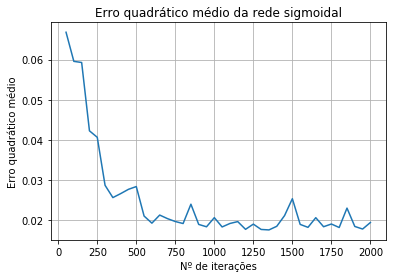

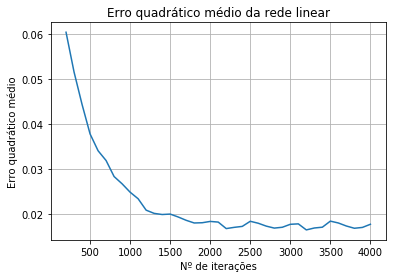

In [13]:
#Leitura do dataset de validação
with open('./dataset_valid.data', newline='') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    dataset_treinamento = np.empty([1, 123])
    for row in reader:
        #print(row)
        dataset_treinamento = np.append(dataset_treinamento, np.array([np.array(row)]), axis=0)

x = dataset_treinamento[1:,:121]
d = np.transpose([dataset_treinamento[1:, 122]])

#Encontrando erro quadrático médio por iteração da rede sigmoidal:
maxD2 = max(abs(d))
##########################
eqm = np.zeros([1, 1])
for i in range(0, len(redeSigmoidal.historicoPesos[0,:]), 50):
    redeSigmoidal.pesos = np.transpose([redeSigmoidal.historicoPesos[:,i]])
    saida_processada = np.empty([len(x[:,0]), 1])
    for k in range(len(x[:,0])):
        redeSigmoidal.set_entradas_pós(np.array([x[k,:]]), normalizar=True)
        saida_processada[k] = (redeSigmoidal.proc_saida(redeSigmoidal.vetor_entradas, True) - 0.5)*2*maxD2
    erros = d - saida_processada
    eqm = np.append(eqm, np.mean(erros**2))
    #print('Peso: {}'.format(i))
print('EQM final da rede sigmoidal: {}'.format(eqm[len(eqm)-1]))

plt.figure()
plt.plot(range(0, len(redeSigmoidal.historicoPesos[0,:]), 50), eqm[1:])
plt.grid()
plt.title('Erro quadrático médio da rede sigmoidal')
plt.xlabel('Nº de iterações')
plt.ylabel('Erro quadrático médio')

#Encontrando erro quadrático médio por iteração da rede linear:
eqm = np.zeros([1, 1])
for i in range(0, len(redeLinear.historicoPesos[0,:]), 100):
    redeLinear.pesos = np.transpose([redeLinear.historicoPesos[:,i]])
    saida_processada = np.empty([len(x[:,0]), 1])
    for k in range(len(x[:,0])):
        redeLinear.set_entradas_pós(np.array([x[k,:]]), normalizar=True)
        saida_processada[k] = redeLinear.proc_saida(redeLinear.vetor_entradas, True)
    erros = d - saida_processada
    eqm = np.append(eqm, np.mean(erros**2))
    #print('Peso: {}'.format(i))
print('EQM final da rede linear: {}'.format(eqm[len(eqm)-1]))

plt.figure()
plt.plot(range(200, len(redeLinear.historicoPesos[0,:]), 100), eqm[3:])
plt.grid()
plt.title('Erro quadrático médio da rede linear')
plt.xlabel('Nº de iterações')
plt.ylabel('Erro quadrático médio')
plt.show()

Para este problema de predição de crimes violentos percebe-se que ambas as redes apresentaram o erro bem próximo, porém a rede neural linear apresentou erro menor. Novamente, a convergência da rede neural sigmoidal foi muito mais rápida, necessitando de aproximadamente 50 iterações par alcançar um erro bem pequeno. A rede linear, por outro lado, precisou de aproximadamente 3000 iterações para alcançar o mesmo resultado.

# 4 Conlusão

A partir dos testes realizados pode-se concluir que não não existe um tipo de rede neural melhor que outro tipo. Tudo depende da aplicação. Nos testes realizados com a regressão da função matemática, a rede neural sigmoidal se saiu muito melhor que a linear, visto que a função matemática utilizada não era uma função linear. Por outro lado, na predição de crimes a rede neural linear apresentou erro menor que a rede neural sigmoidal, mostrando assim que o desempenho de cada rede depende da aplicação.